In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV filcondae I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import matplotlib.pyplot as plt
import lightgbm as lgb
from google.colab import drive
drive.mount('/content/drive')
import seaborn as sns # for prettier plots
import plotly.express as px
import datetime
import lightgbm as lgb
import os
from tqdm import tqdm
import time
from sklearn.preprocessing import LabelEncoder

Mounted at /content/drive


In [2]:
data_path = '/content/drive/MyDrive/KAGGLE/Competition/store sales/store data/'

for files in tqdm(os.listdir(data_path)):
    file = files.split('.')[0]
    print(file)
    globals()[str(file) + '_df'] = pd.read_csv(data_path + files)
    time.sleep(0.1)

  0%|          | 0/6 [00:00<?, ?it/s]

item_categories


 17%|█▋        | 1/6 [00:00<00:04,  1.13it/s]

items


 33%|███▎      | 2/6 [00:01<00:03,  1.25it/s]

sales_train


 50%|█████     | 3/6 [00:04<00:05,  1.69s/it]

test


 67%|██████▋   | 4/6 [00:05<00:02,  1.39s/it]

sample_submission


 83%|████████▎ | 5/6 [00:05<00:01,  1.12s/it]

shops


100%|██████████| 6/6 [00:06<00:00,  1.12s/it]


In [3]:
# train data : date / shop_id / item_id / item_price / item_cnt_day
sales_train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
# shops : shop_name / shop_id
shops_df.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [5]:
# items : item_name / item_id / item_category_id
items_df.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [6]:
# item_category : item_category_name / item_category_id
item_categories_df.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [7]:
sales_train_df.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   date            2935849 non-null  object 
 1   date_block_num  2935849 non-null  int64  
 2   shop_id         2935849 non-null  int64  
 3   item_id         2935849 non-null  int64  
 4   item_price      2935849 non-null  float64
 5   item_cnt_day    2935849 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [8]:
# all merge
train_df = sales_train_df.merge(shops_df, on = 'shop_id')
item_df = items_df.merge(item_categories_df, on = 'item_category_id')

train = train_df.merge(item_df, on = 'item_id')

train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.0,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,02.01.2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
2,03.01.2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
3,20.01.2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
4,23.01.2013,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
...,...,...,...,...,...,...,...,...,...,...
2935844,03.10.2015,33,20,21047,1899.0,1.0,"Москва ""Распродажа""",Футболка Borderlands Jack Hero XL,61,Подарки - Атрибутика
2935845,01.10.2015,33,20,21012,1899.0,1.0,"Москва ""Распродажа""",Футболка Assassin's Creed Syndicate Rook S,61,Подарки - Атрибутика
2935846,03.10.2015,33,20,20451,1699.0,1.0,"Москва ""Распродажа""","Фигурка DC Classic 8"" Wonder Women Head Knocker",72,Подарки - Фигурки
2935847,04.10.2015,33,20,20453,5399.0,1.0,"Москва ""Распродажа""",Фигурка DC Universe Online Solomon Grundy Stat...,72,Подарки - Фигурки


# BI

In [9]:
train.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   date                2935849 non-null  object 
 1   date_block_num      2935849 non-null  int64  
 2   shop_id             2935849 non-null  int64  
 3   item_id             2935849 non-null  int64  
 4   item_price          2935849 non-null  float64
 5   item_cnt_day        2935849 non-null  float64
 6   shop_name           2935849 non-null  object 
 7   item_name           2935849 non-null  object 
 8   item_category_id    2935849 non-null  int64  
 9   item_category_name  2935849 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 246.4+ MB


Text(0.5, 1.0, 'item_price')

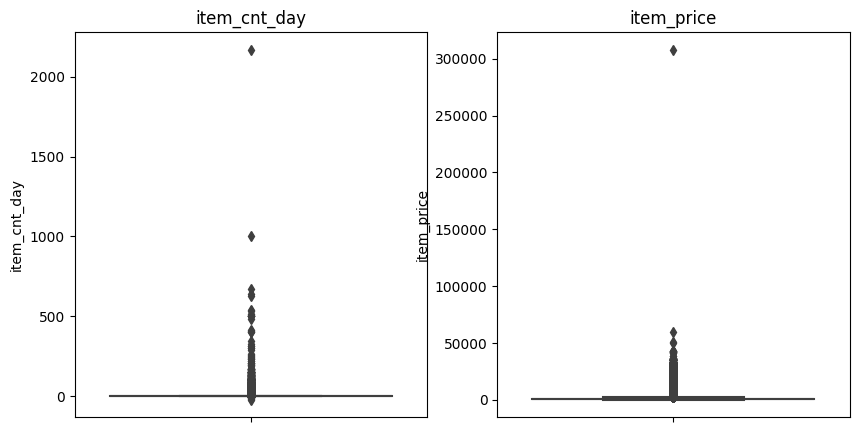

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot(y = 'item_cnt_day', data = train, ax = axes[0]).set_title('item_cnt_day')
sns.boxplot(y = 'item_price', data = train, ax = axes[1]).set_title('item_price')

item_cnt_day는 2000 이상인 제품들이, item_price는 300000 이상인 제품들이 이상치라 판단하여 제거

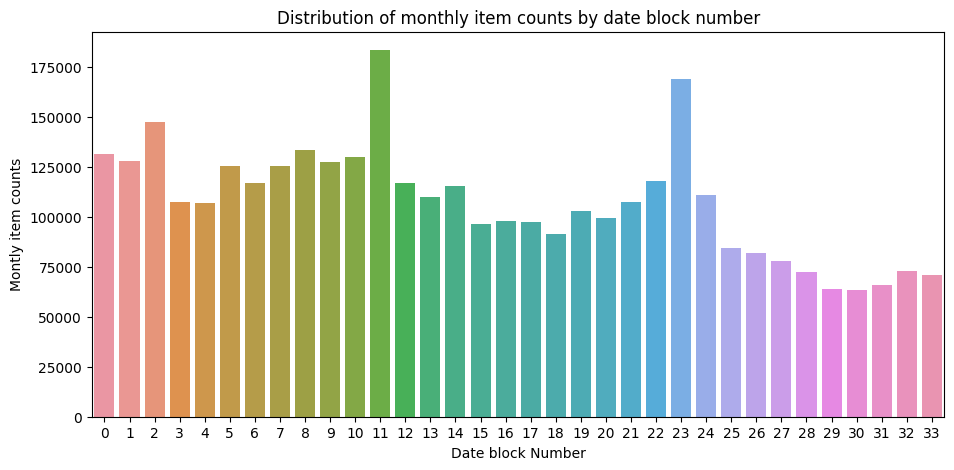

In [11]:
#월별 팔린 판매량
cnt_month = train.groupby('date_block_num').agg({'item_cnt_day':'sum'}).reset_index()

plt.figure(figsize = (11,5))
sns.barplot(x = 'date_block_num', y = 'item_cnt_day', data = cnt_month).set_title('Distribution of monthly item counts by date block number')
plt.xlabel('Date block Number')
plt.ylabel('Montly item counts');

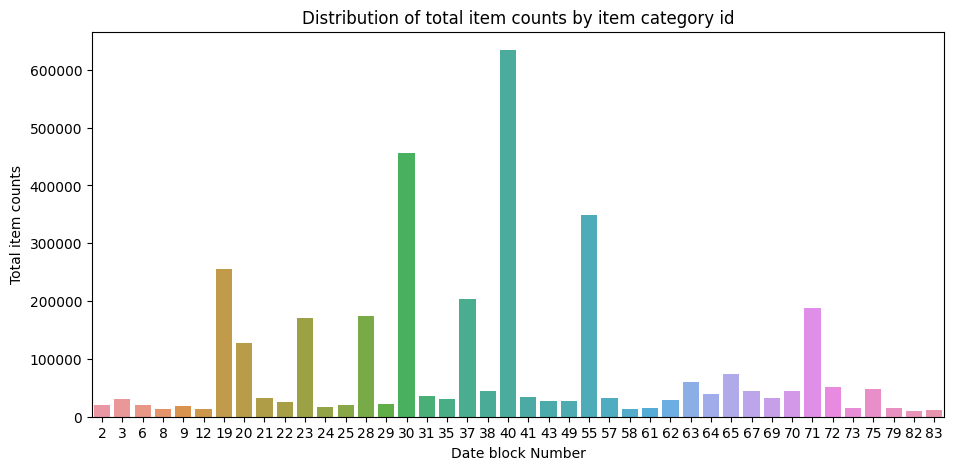

In [12]:
#상품 분류별 판매량
plt.figure(figsize = (11,5))

cnt_category = train.groupby('item_category_id').agg({'item_cnt_day':'sum'}).reset_index()
cnt_category = cnt_category[cnt_category['item_cnt_day']>10000] # 10000개 넘게 팔린 제품들만 보여주기

sns.barplot(x = 'item_category_id', y = 'item_cnt_day', data = cnt_category).set_title('Distribution of total item counts by item category id')
plt.xlabel('Date block Number')
plt.ylabel('Total item counts');

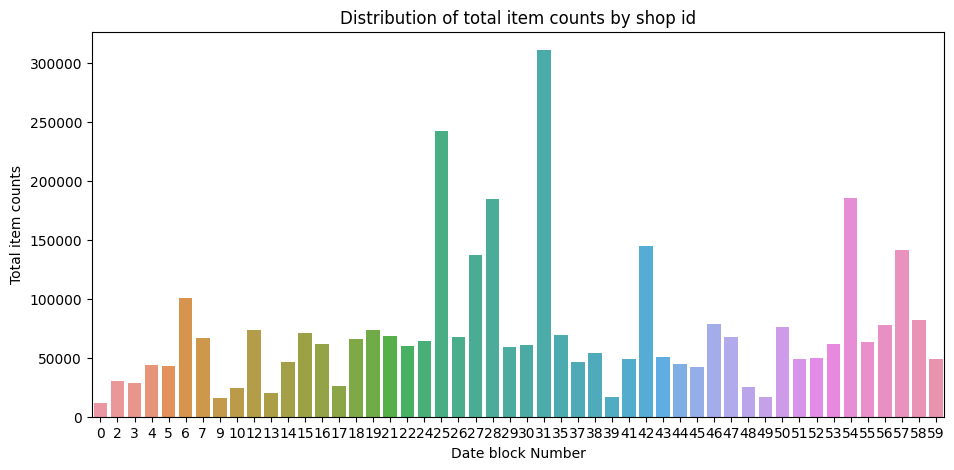

In [13]:
#상점별 판매량
plt.figure(figsize = (11,5))

cnt_shop = train.groupby('shop_id').agg({'item_cnt_day':'sum'}).reset_index()
cnt_shop = cnt_shop[cnt_shop['item_cnt_day']>10000] # 10000개 넘게 팔린 제품들만 보여주기

sns.barplot(x = 'shop_id', y = 'item_cnt_day', data = cnt_shop).set_title('Distribution of total item counts by shop id')
plt.xlabel('Date block Number')
plt.ylabel('Total item counts');

# Preprocessing

In [14]:
#downcasting
def downcast(data, verbose = True):
    start_mem = data.memory_usage().sum()
    for col in data.columns:
        dtype_name = data[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            data[col] = data[col].astype('int8')
        elif dtype_name.startswith('int') or (data[col].round() == data[col]).all():
            data[col] = pd.to_numeric(data[col], downcast = 'integer')
        else:
            data[col] = pd.to_numeric(data[col], downcast = 'float')
    end_mem = data.memory_usage().sum()
    if verbose:
        print('{:.1f}% 압축됨'.format(100*(start_mem - end_mem)/start_mem))
    return data

In [15]:
all_df = [sales_train_df, shops_df, items_df, item_categories_df, test_df]
for df in all_df:
    df = downcast(df)

54.2% 압축됨
38.6% 압축됨
54.2% 압축됨
39.9% 압축됨
70.8% 압축됨


In [16]:
sales_train_df.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')

In [17]:
# feature engineering
# 1. outlier detection
sales_train_df = sales_train_df[(sales_train_df['item_price'] > 0) & (sales_train_df['item_price'] < 50000)]
sales_train_df = sales_train_df[(sales_train_df['item_cnt_day']>0) & (sales_train_df['item_cnt_day']<1000)]

# 2. shop_id edit
sales_train_df.loc[sales_train_df['shop_id'] == 0, 'shop_id'] = 57
sales_train_df.loc[sales_train_df['shop_id'] == 1, 'shop_id'] = 58
sales_train_df.loc[sales_train_df['shop_id'] == 10, 'shop_id'] = 11
sales_train_df.loc[sales_train_df['shop_id'] == 39, 'shop_id'] = 40

test_df.loc[test_df['shop_id'] == 0,'shop_id'] = 57
test_df.loc[test_df['shop_id'] == 1, 'shop_id'] = 58
test_df.loc[test_df['shop_id'] == 10, 'shop_id'] = 11
test_df.loc[test_df['shop_id'] == 39, 'shop_id'] = 40

# 3. feature creation
shops_df['city'] = shops_df['shop_name'].apply(lambda x : x.split()[0].replace('!',''))

label_encoder = LabelEncoder()
shops_df['city'] = label_encoder.fit_transform(shops_df['city'])
shops_df.drop('shop_name', axis = 1, inplace = True)    #도시명 encoding

items_df['first_sale'] = sales_train_df.groupby('item_id').agg({'date_block_num':'min'})['date_block_num']
items_df['first_sale'] = items_df['first_sale'].fillna(34)  #NaN 결측치 채워주기

item_categories_df['big_category'] = item_categories_df['item_category_name'].apply(lambda x : x.split()[0])    #대분류 정리하기

def make_etc(x):
    if len(item_categories_df[item_categories_df['big_category'] == x]) >= 5:
        return x
    else:
        return 'etc'

item_categories_df['big_category'] = item_categories_df['big_category'].apply(make_etc)

label_encoder = LabelEncoder()
item_categories_df['big_category'] = label_encoder.fit_transform(item_categories_df['big_category'])    #대분류 encoding
item_categories_df.drop('big_category', axis = 1, inplace = True)

In [18]:
from itertools import product

def make_zero_cnt(df):
    all_cnt_list = []
    if 'date_block_num' in df.columns:
        for month in df.date_block_num.unique():
            all_shop = df.loc[df['date_block_num'] == month, 'shop_id'].unique()
            all_item = df.loc[df['date_block_num'] == month, 'item_id'].unique()
            all_cnt_list.append(np.array(list(product([month],all_shop,all_item))))

    return_df = pd.DataFrame(np.vstack(all_cnt_list), columns = ['date_block_num','shop_id','item_id'] )
    return return_df

train = make_zero_cnt(sales_train_df)

In [19]:
# 월간 판매량 추가
monthly_sales = sales_train_df.groupby(['date_block_num', 'item_id','shop_id']).agg({'item_cnt_day':'sum', 'item_price':'mean'}).reset_index()
count_sales = sales_train_df.groupby(['date_block_num', 'item_id','shop_id']).agg({'item_cnt_day':'count'}).reset_index()
train = train.merge(monthly_sales, on = ['date_block_num', 'item_id','shop_id'], how = 'left').fillna(0).rename(columns = {'item_cnt_day':'item_cnt_month','item_price':'mean_price'})
train = train.merge(count_sales, on = ['date_block_num', 'item_id','shop_id'], how = 'left').fillna(0).rename(columns = {'item_cnt_day':'sales_count'})

train

,date_block_num,shop_id,item_id,item_cnt_month,mean_price,sales_count
0,0,59,22154,1.0,999.0,1.0
1,0,59,2552,0.0,0.0,0.0
2,0,59,2554,0.0,0.0,0.0
3,0,59,2555,0.0,0.0,0.0
4,0,59,2564,0.0,0.0,0.0
...,...,...,...,...,...,...
10812763,33,21,7635,0.0,0.0,0.0
10812764,33,21,7638,0.0,0.0,0.0
10812765,33,21,7640,0.0,0.0,0.0
10812766,33,21,7632,0.0,0.0,0.0


In [20]:
# test 이어붙이기
test_df['date_block_num'] = 34
all_data = pd.concat([train, test_df.drop('ID', axis = 1)]).reset_index().fillna(0)

# 다른 df 이어붙이기
all_data = all_data.merge(shops_df, on = 'shop_id', how = 'left')
all_data = all_data.merge(items_df, on = 'item_id', how = 'left')
all_data = all_data.merge(item_categories_df, on = 'item_category_id', how = 'left')

all_data = downcast(all_data)

all_data.head()

45.9% 압축됨


,index,date_block_num,shop_id,item_id,item_cnt_month,mean_price,sales_count,city,item_name,item_category_id,first_sale,item_category_name
0,0,0,59,22154,1,999.0,1,30,ЯВЛЕНИЕ 2012 (BD),37,0,Кино - Blu-Ray
1,1,0,59,2552,0,0.0,0,30,DEEP PURPLE The House Of Blue Light LP,58,0,Музыка - Винил
2,2,0,59,2554,0,0.0,0,30,DEEP PURPLE Who Do You Think We Are LP,58,0,Музыка - Винил
3,3,0,59,2555,0,0.0,0,30,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,0,Музыка - CD фирменного производства
4,4,0,59,2564,0,0.0,0,30,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,0,Музыка - Музыкальное видео


In [21]:
# monthly sales feature 생성
def add_mean_feature(df, mean_features, idx_features):
    # 가정 생성
    assert (idx_features[0] == 'date_block_num') and len(idx_features) in [2,3]
    # idx_feature input에 따른 분기
    if len(idx_features) == 2:
        feature_name = idx_features[1] + ' monthly mean sales'
    else:
        feature_name = idx_features[1] + ' ' + idx_features[2] + ' mean sales'
    # 월간 판매량 집계
    group = df.groupby(idx_features).agg({'item_cnt_month':'mean'}).reset_index().rename(columns = {'item_cnt_month':feature_name})
    # df와 group 병합
    df = df.merge(group, on = idx_features, how = 'left')
    # downcast
    df = downcast(df)
    # mean features에 새로 만든 feature 추가
    mean_features.append(feature_name)

    return df, mean_features

In [22]:
item_mean_features = []
all_data, item_mean_features = add_mean_feature(all_data, item_mean_features, ['date_block_num', 'item_id'])    # 월 / 상품별로 그룹화한 평균 판매량 추가
all_data, item_mean_features = add_mean_feature(all_data, item_mean_features, ['date_block_num', 'item_id', 'city'])    # 월 / 상품 / 도시별로 그룹화한 평균 판매량 추가

7.4% 압축됨
6.9% 압축됨


In [23]:
shop_mean_features = []
all_data, shop_mean_features = add_mean_feature(all_data, shop_mean_features, ['date_block_num', 'shop_id', 'item_category_id'])    # 월 / 상점 / 카테고리 별로 그룹화한 평균 판매량 추가

6.5% 압축됨


In [25]:
print(item_mean_features, shop_mean_features)

['item_id monthly mean sales', 'item_id city mean sales'] ['shop_id item_category_id mean sales']


In [26]:
# lag feature 생성
def add_lag_feature(df, lag_features_to_clip, idx_features, lag_feature, nlags = 3, clip = False):
    df_temp = df[idx_features + [lag_feature]].copy()
    # lag feature 생성
    for i in range(1,nlags + 1):
        lag_feature_name = lag_feature + '_lag '+str(i)
        df_temp['date_block_num'] = df_temp['date_block_num'] + 1
        df = df.merge(df_temp.rename(columns = {lag_feature:lag_feature_name}), on = idx_features, how = 'left')
        if clip:
            lag_features_to_clip.append(lag_feature_name)
    df.fillna(0, inplace=True)
    #downcast
    df = downcast(df, verbose=False)

    return df, lag_features_to_clip

In [27]:
lag_features_to_clip = []
idx_features = ['date_block_num', 'shop_id', 'item_id']

# monthly sales의 lag feature 구하기
all_data, lag_features_to_clip = add_lag_feature(
                                                all_data,
                                                lag_features_to_clip,
                                                idx_features,
                                                lag_feature = 'item_cnt_month',
                                                nlags = 3,
                                                clip = True
                                            )
all_data.head()

,index,date_block_num,shop_id,item_id,item_cnt_month,mean_price,sales_count,city,item_name,item_category_id,first_sale,item_category_name,item_id monthly mean sales,item_id city mean sales,shop_id item_category_id mean sales,item_cnt_month_lag 1,item_cnt_month_lag 2,item_cnt_month_lag 3
0,0,0,59,22154,1,999.0,1,30,ЯВЛЕНИЕ 2012 (BD),37,0,Кино - Blu-Ray,0.400000,1.0,0.088496,0,0,0
1,1,0,59,2552,0,0.0,0,30,DEEP PURPLE The House Of Blue Light LP,58,0,Музыка - Винил,0.022222,0.0,0.000000,0,0,0
2,2,0,59,2554,0,0.0,0,30,DEEP PURPLE Who Do You Think We Are LP,58,0,Музыка - Винил,0.022222,0.0,0.000000,0,0,0
3,3,0,59,2555,0,0.0,0,30,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,0,Музыка - CD фирменного производства,0.044444,0.0,0.008333,0,0,0
4,4,0,59,2564,0,0.0,0,30,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,0,Музыка - Музыкальное видео,0.111111,0.0,0.011976,0,0,0


In [28]:
# sales_count의 lag feature 구하기
all_data, lag_features_to_clip = add_lag_feature(
                                                all_data,
                                                lag_features_to_clip,
                                                idx_features,
                                                lag_feature = 'sales_count',
                                                nlags = 3,
                                                clip = True
                                            )
# mean_price의 lag feature 구하기
all_data, lag_features_to_clip = add_lag_feature(
                                                all_data,
                                                lag_features_to_clip,
                                                idx_features,
                                                lag_feature = 'mean_price',
                                                nlags = 3,
                                                clip = True
                                            )
# item_mean_features들에 대해 각각 lag feature 구하기
for item_mean_feature in item_mean_features:
    all_data, lag_features_to_clip = add_lag_feature(
                                                    all_data,
                                                    lag_features_to_clip,
                                                    idx_features,
                                                    lag_feature = item_mean_feature,
                                                    nlags = 3,
                                                    clip = True
                                                )
# item_mean_features 제거
all_data = all_data.drop(item_mean_features, axis = 1)

# shop_mean_features들에 대해 각각 lag feature 구하기
for shop_mean_feature in shop_mean_features:
    all_data, lag_features_to_clip = add_lag_feature(
                                                    all_data,
                                                    lag_features_to_clip,
                                                    idx_features,
                                                    lag_feature = shop_mean_feature,
                                                    nlags = 3,
                                                    clip = True
                                                )
# shop_mean_features 제거
all_data = all_data.drop(shop_mean_features, axis = 1)

In [30]:
# date_block_num이 3 이하인 데이터 제거(lag data가 의미가 없으므로)
all_data = all_data[all_data['date_block_num'] >= 3]

In [34]:
# 추가 feature 생성
# 월간 판매량의 시차 정보 mean 계산 / feature 값 조정(0~20)
all_data['lag_sales_mean'] = all_data[['item_cnt_month_lag 1','item_cnt_month_lag 2','item_cnt_month_lag 3']].mean(axis = 1)
all_data[lag_features_to_clip + ['lag_sales_mean','item_cnt_month']] = all_data[lag_features_to_clip + ['lag_sales_mean','item_cnt_month']].clip(0,20)

# 시차 변화량 계산
all_data['lag_change_1'] = all_data['item_cnt_month_lag 1'] / all_data['item_cnt_month_lag 2']
all_data['lag_change_1'] = all_data['lag_change_1'].replace([np.inf, -np.inf], np.nan).fillna(0)
all_data['lag_change_2'] = all_data['item_cnt_month_lag 2'] / all_data['item_cnt_month_lag 3']
all_data['lag_change_2'] = all_data['lag_change_2'].replace([np.inf, -np.inf], np.nan).fillna(0)


# new 제품 여부
all_data['new_product'] = all_data['first_sale'] == all_data['date_block_num']
all_data['after_new'] = all_data['date_block_num'] - all_data['first_sale']

# month 계산
all_data['month'] = all_data['date_block_num'] % 12

# 필요 없는 feature 제거
all_data = all_data.drop(['first_sale','mean_price','sales_count','index','item_name'], axis = 1)

# item category name label encdoing 진행
label_encoder = LabelEncoder()
all_data['item_category_name'] = label_encoder.fit_transform(all_data['item_category_name'])

# downcast
all_data = downcast(all_data, False)

In [41]:
label_encoder = LabelEncoder()
all_data['item_category_name'] = label_encoder.fit_transform(all_data['item_category_name'])

In [42]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9904582 entries, 1122386 to 11026967
Data columns (total 31 columns):
 #   Column                                     Dtype  
---  ------                                     -----  
 0   date_block_num                             int8   
 1   shop_id                                    int8   
 2   item_id                                    int16  
 3   item_cnt_month                             int8   
 4   city                                       int8   
 5   item_category_id                           int8   
 6   item_category_name                         int64  
 7   item_cnt_month_lag 1                       int8   
 8   item_cnt_month_lag 2                       int8   
 9   item_cnt_month_lag 3                       int8   
 10  sales_count_lag 1                          int8   
 11  sales_count_lag 2                          int8   
 12  sales_count_lag 3                          int8   
 13  mean_price_lag 1                   

In [46]:
# all data에서 test / train 나누기
x_train = all_data[all_data['date_block_num'] < 33]
x_train = x_train.drop(['item_cnt_month'], axis = 1)

x_valid = all_data[all_data['date_block_num'] == 33]
x_valid = x_valid.drop(['item_cnt_month'], axis = 1)

x_test = all_data[all_data['date_block_num'] == 34]
x_test = x_test.drop(['item_cnt_month'], axis = 1)

y_train = all_data[all_data['date_block_num'] < 33]['item_cnt_month']
y_valid = all_data[all_data['date_block_num'] == 33]['item_cnt_month']

# Model 구축

In [61]:
from lightgbm.callback import early_stopping
from typing_extensions import ParamSpecArgs
import lightgbm as lgb

#파라미터 설정
params = {'metric' : 'rmse',
          'num_leaves' : 255,
          'learning_rate' : 0.005,
          'feature_fraction' : 0.75,
          'bagging_fraction' : 0.75,
          'bagging_freq':5,
          'force_col_wise':True,
          'random_state':10}

cat_features = ['shop_id','city','item_category_id','item_category_name','month']

# lgb train and valid dataset
dtrain = lgb.Dataset(x_train, y_train)
dvalid = lgb.Dataset(x_valid, y_valid)

# Train LightGBM model
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      num_boost_round=2400,
                      valid_sets=(dtrain, dvalid),
                      categorical_feature=cat_features,
                      callbacks = [early_stopping(150)])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 3203
[LightGBM] [Info] Number of data points in the train set: 9452298, number of used features: 30
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.297707
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[1468]	training's rmse: 0.754345	valid_1's rmse: 0.886868


In [63]:
preds = lgb_model.predict(x_test).clip(0,20)
submission = pd.DataFrame([])
submission['item_cnt_month'] = preds
submission.to_csv('submission.csv', index = False)